In [1]:
# Group 6: Amy Law, Benjamin Mann, Fuyu Wang, Weipeng Wang
# Reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html?highlight=gan

In [2]:
# import the library
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data.dataset import ConcatDataset

In [21]:
dataroot = "./images/"
dataroot2 = "./images-fake/"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

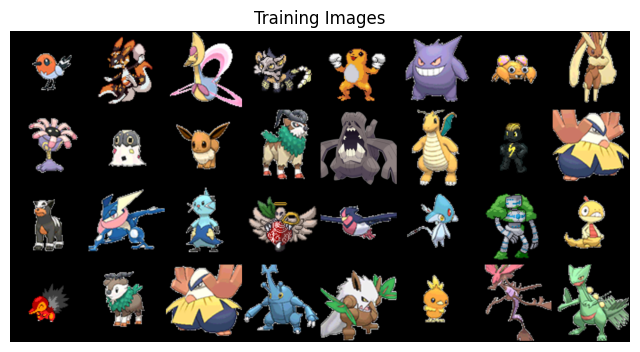

In [5]:
# We set up the dataset by using the ImageFolder
# The mirror dataset includes the original image but randomly fliped in the horizontal direction
# The fake dataset includes the fake pokemons (fan-made pokemons)
original = dset.ImageFolder(root = dataroot, transform = transforms.Compose([transforms.Resize(180),
                                                                           transforms.CenterCrop(128),
                                                                           transforms.ToTensor(),
                                                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                                           ]))

mirror = dset.ImageFolder(root = dataroot, transform = transforms.Compose([transforms.Resize(180),
                                                                           transforms.CenterCrop(128),
                                                                           transforms.RandomHorizontalFlip(p=1.0),
                                                                           transforms.ToTensor(),
                                                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                                           ]))

fake = dset.ImageFolder(root = dataroot2, transform = transforms.Compose([transforms.Resize(128),
                                                                           transforms.CenterCrop(128),
                                                                           transforms.ToTensor(),
                                                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                                           ]))

# Set the batch size as 32
data_types = [original, fake, mirror]
dataset = ConcatDataset(data_types)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)

# Check the images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [6]:
# Set up the Weight
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [7]:
# Build the discriminator architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 4, stride = 4, padding = 1, bias = False)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 4, stride = 4, padding = 1, bias = False)
        self.conv4 = nn.Conv2d(128, 1, kernel_size = 4, stride = 1, padding = 0, bias = False)
        
        self.batch1 = nn.BatchNorm2d(32)
        self.batch2 = nn.BatchNorm2d(64)
        self.batch3 = nn.BatchNorm2d(128)

        self.activation = nn.LeakyReLU(0.2, inplace = True)
        self.dropout = nn.Dropout(p = 0.40)
    
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.batch2(self.conv2(x)))
        x = self.dropout(x)
        x = self.activation(self.batch3(self.conv3(x)))
        x = self.conv4(x)

        return nn.Sigmoid()(x)

In [8]:
# Build the generator architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
 
        self.conv1 = nn.ConvTranspose2d(64, 2048, kernel_size = 4, stride = 1, padding = 0, bias = False)
        self.conv2 = nn.ConvTranspose2d(2048, 512, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv3 = nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv4 = nn.ConvTranspose2d(256, 64, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv5 = nn.ConvTranspose2d(64, 32, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv6 = nn.ConvTranspose2d(32, 3, kernel_size = 4, stride = 2, padding = 1, bias = False)

        
        self.batch1 = nn.BatchNorm2d(2048)
        self.batch2 = nn.BatchNorm2d(512)
        self.batch3 = nn.BatchNorm2d(256)
        self.batch4 = nn.BatchNorm2d(64)

        self.activation = nn.ReLU(True)
        self.dropout = nn.Dropout(p = 0.15)
        
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.batch2(self.conv2(x)))
        x = self.activation(self.batch3(self.conv3(x)))
        x = self.dropout(x)
        x = self.activation(self.batch4(self.conv4(x)))
        x = self.activation(self.conv5(x))
        x = self.conv6(x)

        return nn.Tanh()(x)

In [9]:
# Set the hyperparameters
epoch_num = 250
loss = nn.BCELoss()
iteration = 0

discriminator = Discriminator().to(device)
generator = Generator().to(device)

discriminator.apply(weights_init)
generator.apply(weights_init)

# Set up the optimizers
d_opt = torch.optim.RMSprop(discriminator.parameters(), lr = 0.0002)
g_opt = optim.Adam(generator.parameters(), lr = 0.0001, betas=(0.5, 0.999))

# The list are used to store the outputs (discriminator/generator loss values, D(x), D(G(X)), and generated images)
d_loss_values = []
g_loss_values = []
d_x_list = []
d_g_x_before_list = []
d_g_x_after_list = []
generated_images = []

# After each training, we would use the test_noise to generate the images and we can check the image quality later
test_noise = torch.randn(32, 64, 1, 1, device = device)

In [10]:
# Train the generator and discriminator

for epoch in range(epoch_num):
  for index, (img_data, _) in enumerate(dataloader, 0):

    # Part I. Train the Discriminator
    discriminator.zero_grad()
    real_image = img_data.to(device)

    # Train the Discriminator with real images
    real_label = (0.1 - torch.rand((real_image.shape[0],)) * 0.1).to(device)
    
    # We generate the output by activating Discriminator
    real_output = discriminator(real_image)

    # Train the Discriminator with fake images
    # Fake images will be generated by the Generator
    noise = torch.randn(real_image.shape[0], 64, 1, 1, device = device)

    # Generate the fake image by the Generator
    fake_image = generator(noise)
    fake_label = (0.9 + torch.rand((real_image.shape[0],)) * 0.1).to(device)
    
    # Get the output by Discriminator
    #print(fake_image.size())
    fake_output = discriminator(fake_image.detach())

    # Compute the loss value for real_image and fake_image inputs
    d_real_loss = loss(real_output.view(-1), real_label)
    d_fake_loss = loss(fake_output.view(-1), fake_label)

    # Calculate the possibility
    d_x = real_output.view(-1).mean().item()
    g_x_before = fake_output.view(-1).mean().item()

    # Do the backward
    d_real_loss.backward()
    d_fake_loss.backward()
    d_opt.step()
    
    # Calculate the overall d_loss
    d_loss = d_real_loss + d_fake_loss

    # Part II. Train the Generator
    generator.zero_grad()
    real_label = (0.1 - torch.rand((real_image.shape[0],)) * 0.1).to(device)
    # Get the Discriminator output by using fake images generated before
    fake_output = discriminator(fake_image)

    # Calculate the loss value for the Generator
    g_loss = loss(fake_output.view(-1), real_label)
    g_loss.backward()
    g_opt.step()

    # Calculate the possibility
    g_x_after = fake_output.view(-1).mean().item()

    # Print out the loss values
    if index % 150 == 0:
      print('Epoch {}: Discriminator Loss: {:.6f} | Generator Loss: {:.6f} \n| D(x): {:.6f} | D(G(z)) (Before D updated): {:.6f} | D(G(z)) (After D updated): {:.6f}'.format(epoch, d_loss.item(), g_loss.item(), d_x, g_x_before, g_x_after))
      
      # Record the values for further analyzation
      d_loss_values.append(d_loss.item())
      g_loss_values.append(g_loss.item())

      d_x_list.append(d_x)
      d_g_x_before_list.append(g_x_before)
      d_g_x_after_list.append(g_x_after)


    # Save the images generated by the Generator
    if (iteration % 250 == 0) or (epoch == epoch_num - 1 and index == len(dataloader) - 1):
      with torch.no_grad():
        image = generator(test_noise).detach().cpu()
      generated_images.append(vutils.make_grid(image, padding = 2, normalize = True))

    iteration += 1

Epoch 0: Discriminator Loss: 1.408633 | Generator Loss: 3.264088 
| D(x): 0.477734 | D(G(z)) (Before D updated): 0.509204 | D(G(z)) (After D updated): 0.961991
Epoch 1: Discriminator Loss: 0.694126 | Generator Loss: 3.936513 
| D(x): 0.201697 | D(G(z)) (Before D updated): 0.741641 | D(G(z)) (After D updated): 0.979987
Epoch 2: Discriminator Loss: 0.462961 | Generator Loss: 3.154168 
| D(x): 0.066052 | D(G(z)) (Before D updated): 0.930435 | D(G(z)) (After D updated): 0.956941
Epoch 3: Discriminator Loss: 0.447046 | Generator Loss: 4.075121 
| D(x): 0.079475 | D(G(z)) (Before D updated): 0.894784 | D(G(z)) (After D updated): 0.983378
Epoch 4: Discriminator Loss: 0.802559 | Generator Loss: 7.905806 
| D(x): 0.054202 | D(G(z)) (Before D updated): 0.577590 | D(G(z)) (After D updated): 0.999711
Epoch 5: Discriminator Loss: 0.579769 | Generator Loss: 5.008977 
| D(x): 0.073622 | D(G(z)) (Before D updated): 0.740678 | D(G(z)) (After D updated): 0.992358
Epoch 6: Discriminator Loss: 1.403813 | 

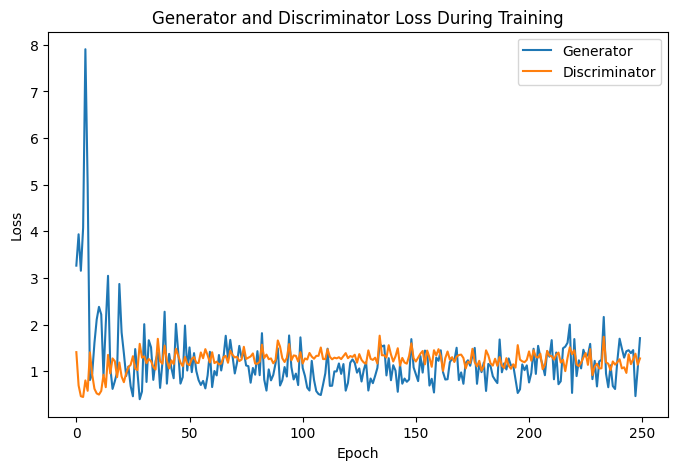

In [11]:
# Plot the discriminator and generator loss
# It can help us evaluate the performance of the GAN model
plt.figure(figsize=(8,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss_values,label="Generator")
plt.plot(d_loss_values,label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

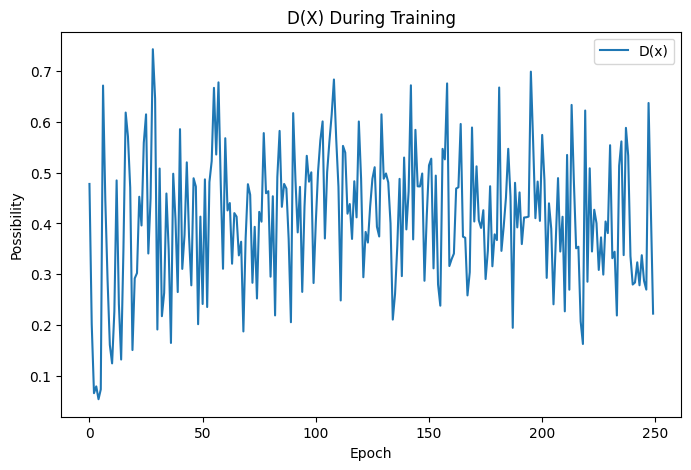

In [12]:
# Plot the D(X)
plt.figure(figsize=(8,5))
plt.title("D(X) During Training")
plt.plot(d_x_list,label="D(x)")
plt.xlabel("Epoch")
plt.ylabel("Possibility")
plt.legend()
plt.show()

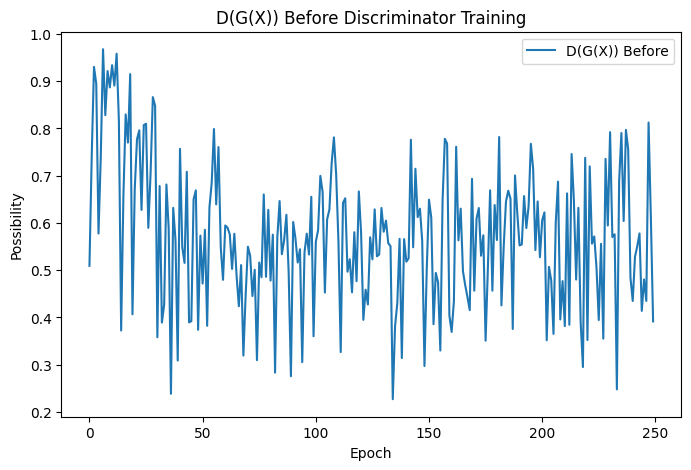

In [13]:
# Plot the D(G(X)) before discriminator training
plt.figure(figsize=(8,5))
plt.title("D(G(X)) Before Discriminator Training")
plt.plot(d_g_x_before_list,label="D(G(X)) Before")
plt.xlabel("Epoch")
plt.ylabel("Possibility")
plt.legend()
plt.show()

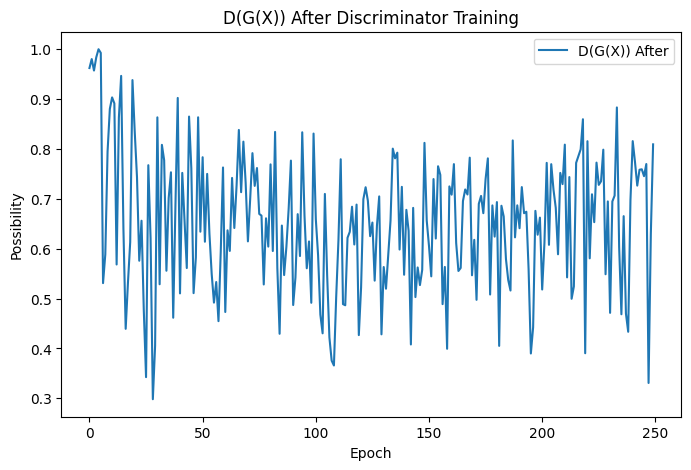

In [14]:
# Plot the D(G(X)) after discriminator training
plt.figure(figsize=(8,5))
plt.title("D(G(X)) After Discriminator Training")
plt.plot(d_g_x_after_list,label="D(G(X)) After")
plt.xlabel("Epoch")
plt.ylabel("Possibility")
plt.legend()
plt.show()

In [15]:
# Print out the minimum and maximum values
# Helpful for us to make some inclusions
print("Minimum discriminator loss value: ", min(d_loss_values))
print("Maximum discriminator loss value: ", max(d_loss_values))
print("Minimum generator loss value: ", min(g_loss_values))
print("Maximum generator loss value: ", max(g_loss_values))
print("Minimum D(x): ", min(d_x_list))
print("Maximum D(x): ", max(d_x_list))
print("Minimum G(D(X)) before discriminator training: ", min(d_g_x_before_list))
print("Maximum G(D(X)) before discriminator training: ", max(d_g_x_before_list))
print("Minimum G(D(X)) after discriminator training: ", min(d_g_x_after_list))
print("Maximum G(D(X)) after discriminator training: ", max(d_g_x_after_list))

Minimum discriminator loss value:  0.4470460116863251
Maximum discriminator loss value:  1.7618834972381592
Minimum generator loss value:  0.39890697598457336
Maximum generator loss value:  7.905806064605713
Minimum D(x):  0.0542021244764328
Maximum D(x):  0.7427844405174255
Minimum G(D(X)) before discriminator training:  0.2267577201128006
Maximum G(D(X)) before discriminator training:  0.967754065990448
Minimum G(D(X)) after discriminator training:  0.29813021421432495
Maximum G(D(X)) after discriminator training:  0.9997107982635498


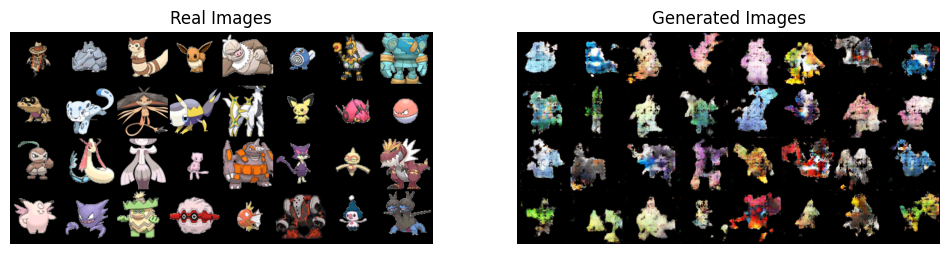

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Get the images from the training set
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Get the images generated by the generator
# generated_images stored images generated by the generator during training
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(generated_images[-1],(1,2,0)))
plt.show()

In [17]:
# Save the model by using torch.save()
model_name = "pokemon_generator.pth"
path = F"./savedModels/{model_name}"
torch.save(generator.state_dict(), path)